In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import copy
import time
import pandas as pd 
import pickle

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [2]:
plt.rcParams['figure.dpi'] = 100

# General configuration

In [3]:
M = 20
T = 90

# Some parameters
num_steps_init = 200
num_steps_online = 1

lamb_ = np.exp(np.log(0.1)/T) 
print(lamb_)


# For the paper experiments
#n_hours = 24  
#list_regions = ['CT', 'ME', 'NEMA', 'NH', 'RI', 'SEMA', 'VT', 'WCMA']

# For debugging
n_hours = 1  
list_regions = ['CT']

0.9747402255566063


# Data generation

In [4]:
# We predict next 24 hours
def generate_data(region='CT', weeks= False):

    file_name = '../data/2020_'+region+'.txt'
    df1 = pd.read_csv(file_name, sep=" ", header=None)
    file_name = '../data/2021_'+region+'.txt'
    df2 = pd.read_csv(file_name, sep=" ", header=None)
    df = pd.concat((df1,df2),  ignore_index=True)
    df.columns =['values']
    n_days = int(df.shape[0]/24)
    
    df.insert(0, "Day", (np.ones((24,1))* np.arange(0,n_days)).T.ravel(), True)
    df2 = df.groupby("Day").agg({"values": lambda x:x.tolist()})
    id_df=df2["values"].apply(lambda x:pd.Series(x))
    id_cols=range(24)
    id_df.columns=id_cols
    df_y = id_df
    df_y = df_y.shift(-1)
    df_y.columns=['pred_value' + str(i) for i in range(24)]
    
    X = id_df.values
    Y = df_y.values

    #Rescale X, Y
    scale_factor =  1000
    X = X /scale_factor
    Y = Y/scale_factor

    #Reshape X and Y by weeks
    if weeks:
      X_week = X[:-6,:]
      for i in range(1,6):
        X_week = np.concatenate((X_week, X[i:-(6-i),:]), axis =1)
      i = 6
      X_week = np.concatenate((X_week, X[i:,:]), axis =1)
      Y_week = Y[6:]
      X = X_week
      Y = Y_week
    else:
      X = X[6:]
      Y = Y[6:]

    # One month for model initialization
    days_init = 90
    X_init = torch.Tensor(X[:days_init])
    y_init = torch.Tensor(Y[:days_init]) 
    X_t = torch.Tensor(X[days_init:-1])
    y_t = torch.Tensor(Y[days_init:-1])

    return X_init, y_init, X_t, y_t 

In [5]:
X_init, y_init, X_t, y_t  = generate_data()

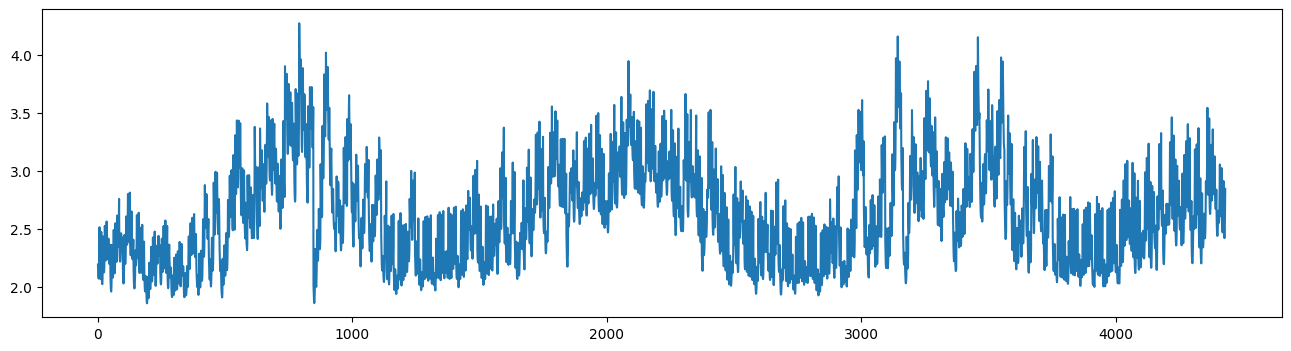

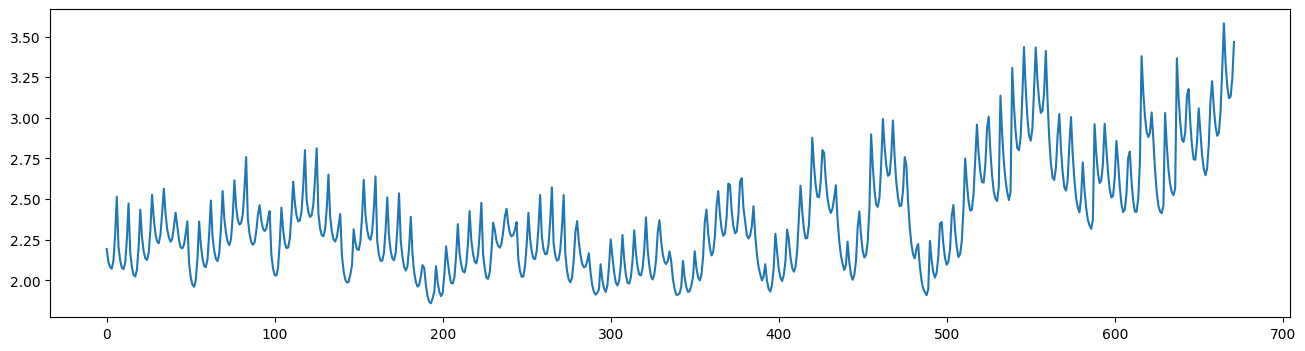

In [6]:
fig = plt.figure(figsize=(16,4))
plt.plot(X_t[:,:7].ravel())
fig = plt.figure(figsize=(16,4))
plt.plot(X_t[:,:7].ravel()[:4*7*24])

# Persistence Baseline

We predict the next day load with the load of the input day at the same time

In [7]:
print('Persistence BASELINE')

Persistence BASELINE


In [8]:
for region in list_regions:
    print(region)
    X_init, y_init, X_t, y_t = generate_data(region= region, weeks = False)

    y_pred = X_t
    mean_pred_baseline1 = y_pred
    MSE_baseline1 = (y_pred-y_t)**2

    data = {'mse':MSE_baseline1,
            'mean':y_pred}

    with open('../results/LF_Persistence_'+region+'.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


CT


# ADAPTIVE MODELS

In [9]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import sys
import inspect

parentdir = "../lib/"
sys.path.insert(0, parentdir) 


from AdaptiveLearningUtilities import model_update_AGP, model_update_FastAGP
from AdaptiveSparseGPRegression import AdaptiveSparseGPRegression 

## Fast-AGP: Adaptive SVGP without inference

Model parameters are NOT updated (only inducing points)

In [12]:
print('Fast-AGP: Adaptive SVGP without inference')

Fast-AGP: Adaptive SVGP without inference


In [13]:
for region in list_regions:
    print(region)

    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    n_inducing_iter = []
    train_time_iter = []
    test_time_iter =[]

    X_init, y_init_24hours, X_t, y_t_24hours = generate_data(region= region)

    for hour in range(n_hours):
      print(hour)
      y_init = torch.squeeze(y_init_24hours[:,hour])
      y_t = torch.squeeze(y_t_24hours[:,hour])
      # initialize pyro
      pyro.clear_param_store()

      # initialize the inducing inputs with the last training samples 
      inducing_points = X_init[-2*M::2,:]
      Xu = torch.Tensor(copy.copy(inducing_points))

      # initialize the kernel
      kernel = gp.kernels.RBF(input_dim=X_init.shape[1]) +gp.kernels.Constant(input_dim=X_init.shape[1])
      
      # Define the model
      osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-4)
   
      # the way we setup inference is similar to above
      optimizer = torch.optim.Adam(osgpr.parameters(), lr=0.05)
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

      # Initialize the model running a complete inference of all the parameters
      for i in range(num_steps_init):
          optimizer.zero_grad()
          loss = loss_fn(osgpr.model, osgpr.guide)
          loss.backward()
          optimizer.step()

      # We update the model with the last inferred parameters to later online learning
      osgpr.update_all_variables()

      mse_pred = []
      mean_pred = []
      std_pred = []
      IC_95 = []
      n_inducing =[] 
      test_time = 0
      train_time = 0
        
      n_inducing = [osgpr.Xu.shape[0]]
    
      for t, (x, y) in enumerate(zip(X_t, y_t)):

          X_new = X_t[t:t+1]
          y_new = y_t[t:t+1]

          start = time.process_time()
          # Compute test error predicting next sample
          with torch.no_grad():
            pred, cov = osgpr(X_new, noiseless=False)
          test_time += (time.process_time()-start) 

          mean_pred.append(pred.numpy())

          mse = (pred-y_new)**2
          mse_pred.append(mse.numpy())

          std = torch.sqrt(cov)
          std_pred.append(std.numpy())
          IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
        
          # Update model
          start = time.process_time()
          loss = model_update_FastAGP(osgpr, X_new, y_new, T= T, M = M, perc_th = 1e-4)
          train_time += (time.process_time()-start) 
            
          n_inducing.append(osgpr.Xu.shape[0])
        
      # Save variables
      mse_pred_iter.append(mse_pred)
      std_pred_iter.append(std_pred)
      mean_pred_iter.append(mean_pred)
      IC_95_iter.append(IC_95)
      n_inducing_iter.append(n_inducing)
      train_time_iter.append(train_time)
      test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'n_inducing':n_inducing_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}
    

    with open('../results/LF_Fast-AGP_'+region+'.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

CT
0


## AGP: Adaptive SVGP with inference

We apply inference over all model parameters

In [14]:
print('AGP: Adaptive SVGP with inference')

AGP: Adaptive SVGP with inference


In [15]:
for region in list_regions:
    print(region)

    mse_pred_iter = []
    std_pred_iter = []
    mean_pred_iter = []
    IC_95_iter = []
    n_inducing_iter = []
    train_time_iter = []
    test_time_iter =[]

    X_init, y_init_24hours, X_t, y_t_24hours = generate_data(region= region)

    for hour in range(n_hours):
      print(hour)
      y_init = torch.squeeze(y_init_24hours[:,hour])
      y_t = torch.squeeze(y_t_24hours[:,hour])

      # initialize the kernel and model
      pyro.clear_param_store()
      kernel = gp.kernels.RBF(input_dim=X_init.shape[1])
      
      # initialize the inducing inputs in interval [0,1] 
      inducing_points = X_init[-2*M::2,:]
      Xu = torch.Tensor(copy.copy(inducing_points))

      # Define the model
      osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-3)

      # the way we setup inference is similar to above
      optimizer = torch.optim.Adam(osgpr.parameters(), lr=0.05)
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

      # Initialize the model running a complete inference of all the parameters
      for i in range(num_steps_init):
          optimizer.zero_grad()
          loss = loss_fn(osgpr.model, osgpr.guide)
          loss.backward()
          optimizer.step()

      # We update the model with the last inferred parameters to later online learning
      osgpr.update_all_variables()

      mse_pred = []
      std_pred = []
      mean_pred = []
      IC_95 = []
      n_inducing =[]
      test_time = 0
      train_time = 0

      #variances=[osgpr.kernel.variance.item()]
      #noises=[osgpr.noise.item()]
      #lengthscales = [osgpr.kernel.lengthscale.item()]
      n_inducing = [osgpr.Xu.shape[0]]

      for t, (x, y) in enumerate(zip(X_t, y_t)):

          X_new = X_t[t:t+1]
          y_new = y_t[t:t+1]

          start = time.process_time()
          # Compute test error predicting next sample
          with torch.no_grad():
            pred, cov = osgpr(X_new, noiseless=False)
          test_time += (time.process_time()-start) 

          mean_pred.append(pred.numpy())

          mse = (pred-y_new)**2
          mse_pred.append(mse.numpy())

          std = torch.sqrt(cov)
          std_pred.append(std.numpy())
          IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
          # Update model
          start = time.process_time()
          loss = model_update_AGP(osgpr, X_new, y_new, T= T, perc_th = 1e-4, optimizer = optimizer, num_steps = num_steps_online)
          train_time += (time.process_time()-start) 
          #variances.append(osgpr.kernel.variance.item())
          #noises.append(osgpr.noise.item())
          #lengthscales.append(osgpr.kernel.lengthscale.item())
          n_inducing.append(osgpr.Xu.shape[0])

      #print(variances)
      #print(noises)
      #print(lengthscales)
      #print(n_inducing)

      # Save variables
      mse_pred_iter.append(mse_pred)
      mean_pred_iter.append(mean_pred)
      std_pred_iter.append(std_pred)
      IC_95_iter.append(IC_95)
      n_inducing_iter.append(n_inducing)
      train_time_iter.append(train_time)
      test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'n_inducing':n_inducing_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/LF_AGP_'+region+'.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

CT
0


## Adaptive VSGP with VSI

In [16]:
print('AGP-VSI: Adaptive VSGP with VSI')

AGP-VSI: Adaptive VSGP with VSI


In [17]:
from AdaptiveELBO import adaptive_elbo

In [18]:
for region in list_regions:
    print(region)
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]


    X_init, y_init_24hours, X_t, y_t_24hours = generate_data(region= region)

    for hour in range(n_hours):
      print(hour)
      y_init = torch.squeeze(y_init_24hours[:,hour])
      y_t = torch.squeeze(y_t_24hours[:,hour])

      # initialize the kernel and model
      pyro.clear_param_store()
      kernel = gp.kernels.RBF(input_dim=X_init.shape[1], variance=torch.tensor(1.0), lengthscale=torch.tensor(1.))
      
      # initialize the inducing inputs in interval [0,1] 
      #inducing_points = X_init[M:,:]
      inducing_points = X_init[-2*M::2,:]
      Xu = torch.Tensor(copy.copy(inducing_points))

      likelihood = gp.likelihoods.Gaussian()

      forget_factor =  torch.flip(torch.cumprod(lamb_*torch.ones_like(y_init), dim=0), [0])
      forget_factor = torch.cat((forget_factor[1:],torch.tensor([1.0])))

      # turn on "whiten" flag for more stable optimization
      vsgp = gp.models.VariationalSparseGP(
          X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
      )

      optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.05)
      loss_fn = adaptive_elbo

      for i in range(num_steps_init):
          optimizer.zero_grad()
          loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
          loss.backward()
          optimizer.step()

      mse_pred = []
      mean_pred = []
      std_pred = []
      IC_95 = []
      test_time = 0
      train_time = 0


      X_window = X_init
      y_window = y_init 

      for t, (x, y) in enumerate(zip(X_t, y_t)):

          X_new = X_t[t:t+1]
          y_new = y_t[t:t+1]

          start = time.process_time()
          # Compute test error predicting next sample
          with torch.no_grad():
            pred, cov = vsgp(X_new)
          test_time += (time.process_time()-start) 

          mean_pred.append(pred.numpy())

          mse = (pred-y_new)**2
          mse_pred.append(mse.numpy())

          cov = cov + vsgp.likelihood.variance
          std = torch.sqrt(cov)
          std_pred.append(std.detach().numpy())
          IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

          start = time.process_time()
          # Update model with new data
          X_window = torch.cat((X_window[1:], X_new))
          y_window = torch.cat((y_window[1:], y_new))

          forget_factor = torch.cat((lamb_*forget_factor[1:],torch.tensor([1.0]))) 

          vsgp.set_data(X_window, y_window)

          for i in range(50*num_steps_online):
              optimizer.zero_grad()
              loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
              loss.backward()
              optimizer.step()
          train_time += (time.process_time()-start) 


      # Save varaibles
      mse_pred_iter.append(mse_pred)
      std_pred_iter.append(std_pred)
      mean_pred_iter.append(mean_pred)
      IC_95_iter.append(IC_95)
      train_time_iter.append(train_time)
      test_time_iter.append(test_time)
    
    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/LF_AGP-VSI_'+region+'.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

CT
0


# BASELINES

## Training a GP per iteration with a sliding data window

In [19]:
print('w-SVGP: A windowed SVGP')

w-SVGP: A windowed SVGP


In [21]:
for region in list_regions:
    print(region)
    
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]


    X_init, y_init_24hours, X_t, y_t_24hours = generate_data(region= region)

    for hour in range(n_hours):
      print(hour)
      y_init = torch.squeeze(y_init_24hours[:,hour])
      y_t = torch.squeeze(y_t_24hours[:,hour])

      # initialize the inducing inputs in interval [0,1] 
      inducing_points = X_init[-2*M::2,:]
      Xu = torch.Tensor(copy.copy(inducing_points))

      # initialize the kernel, likelihood, and model
      pyro.clear_param_store()
      kernel = gp.kernels.RBF(input_dim=X_init.shape[1])
      
      likelihood = gp.likelihoods.Gaussian()
      # turn on "whiten" flag for more stable optimization
      vsgp = gp.models.VariationalSparseGP(
          X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
      )

      # Train the first model
      optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.05)
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

      for i in range(num_steps_init):
          optimizer.zero_grad()
          loss = loss_fn(vsgp.model, vsgp.guide)
          loss.backward()
          optimizer.step()

      mse_pred = []
      mean_pred = []
      std_pred = []
      IC_95 = []
      test_time = 0
      train_time = 0


      X_window = X_init
      y_window = y_init 

      for t, (x, y) in enumerate(zip(X_t, y_t)):

          X_new = X_t[t:t+1]
          y_new = y_t[t:t+1]

          start = time.process_time()
          # Compute test error predicting next sample
          with torch.no_grad():
            pred, cov = vsgp(X_new)
          test_time += (time.process_time()-start) 

          mean_pred.append(pred.numpy())

          mse = (pred-y_new)**2
          mse_pred.append(mse.numpy())

          cov = cov + vsgp.likelihood.variance
          std = torch.sqrt(cov)
          std_pred.append(std.detach().numpy())
          IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

          start = time.process_time()
          # Update model with new data
          X_window = torch.cat((X_window[1:], X_new))
          y_window = torch.cat((y_window[1:], y_new))

          vsgp.set_data(X_window, y_window)

          for i in range(50*num_steps_online):
              optimizer.zero_grad()
              loss = loss_fn(vsgp.model, vsgp.guide)
              loss.backward()
              optimizer.step()
          train_time += (time.process_time()-start) 



      # Save varaibles
      mse_pred_iter.append(mse_pred)
      std_pred_iter.append(std_pred)
      mean_pred_iter.append(mean_pred)
      IC_95_iter.append(IC_95)
      train_time_iter.append(train_time)
      test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/LF_w-SVGP_'+region+'.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

CT
0


## Online SGP

This is the model proposed in:

https://arxiv.org/pdf/1705.07131.pdf

https://github.com/thangbui/streaming_sparse_gp/blob/b46e6e4a9257937f7ca26ac06099f5365c8b50d8/code/osgpr.py

But here, we used the pythorch iomplementation included in

https://github.com/wjmaddox/online_gp



In [22]:
import sys
sys.path.append('../experiments/regression/')

from copy import deepcopy

import math

import gpytorch
from gpytorch import mlls
from online_gp import models



In [23]:
print('OSGP: Online SGP ')

OSGP: Online SGP 


In [24]:
for region in list_regions:
    print(region)
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]
   
    # Some regions generate convergence problems
    X_init, y_init_24hours, X_t, y_t_24hours = generate_data(region= region)

    for hour in range(n_hours):
        try:
            print(hour)
            y_init = torch.squeeze(y_init_24hours[:,hour])
            y_t = torch.squeeze(y_t_24hours[:,hour])
            # initialize pyro
            pyro.clear_param_store()



            init_x= X_init
            init_y= y_init[:,None]
            X = X_t
            Y = y_t[:,None]

            # Initialize the model
            covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            
            # initialize the inducing inputs with the last training samples 
            inducing_points =copy.copy(init_x[-2*M::2,:])

            osgpr_model = models.StreamingSGPR(inducing_points, learn_inducing_locations=True, 
                                        covar_module=covar_module, num_data=init_x.size(0), jitter=1e-3)

            # Training a initial GP as starting point

            elbo = mlls.VariationalELBO(osgpr_model.likelihood, osgpr_model, num_data=init_x.size(0))
            mll = mlls.ExactMarginalLogLikelihood(osgpr_model.likelihood, osgpr_model)
            trainable_params = [
            dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
            dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
            dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
            dict(params=osgpr_model.variational_strategy._variational_distribution.parameters(), lr=1e-2)
            ]
            optimizer = torch.optim.Adam(trainable_params)
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 400, 1e-4)

            osgpr_model.train()
            records = []
            for i in range(num_steps_init):
                optimizer.zero_grad()
                train_dist = osgpr_model(init_x)
                loss = -elbo(train_dist, init_y.squeeze(-1)).sum()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            osgpr_model.eval()
            osgpr_model = osgpr_model.get_fantasy_model(init_x, init_y, resample_ratio=0)

            mse_pred = []
            mean_pred = []
            std_pred = []
            IC_95 = []
            test_time = 0
            train_time = 0

            chunk_size = T

            for t, (x, y) in enumerate(zip(X, Y)):

                X_new =  X[t:t+1]
                y_new = Y[t:t+1]

                # Compute test error predicting next sample
                start = time.process_time()  
                with torch.no_grad():
                    pred, cov = osgpr_model.predict(X_new)
                test_time += (time.process_time()-start) 

                mean_pred.append(pred.numpy())

                mse = (pred-y_new)**2
                mse_pred.append(mse.numpy())

                std = torch.sqrt(cov)
                std_pred.append(std.detach().numpy())
                IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

                start = time.process_time()
                elbo = models.StreamingSGPRBound(osgpr_model)
                trainable_params = [
                  dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
                  dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
                  dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
                ]
                optimizer = torch.optim.Adam(trainable_params)

                for _ in range(num_steps_online):
                    optimizer.zero_grad()
                    loss = -elbo(x.view(-1, 1).T, y.view(-1, 1))
                    loss.backward()
                    optimizer.step()

                osgpr_model = osgpr_model.get_fantasy_model(x.view(-1, 1).T, y.view(-1, 1), resample_ratio=0)
                train_time += (time.process_time()-start) 

            # Save variables
            mse_pred_iter.append(mse_pred)
            std_pred_iter.append(std_pred)
            mean_pred_iter.append(mean_pred)
            IC_95_iter.append(IC_95)
            train_time_iter.append(train_time)
            test_time_iter.append(test_time)
            
        except:
            print('Error... Region '+region+ ' hour ' +str(hour) )
            mse_pred_iter.append([np.nan])
            std_pred_iter.append([np.nan])
            mean_pred_iter.append([np.nan])
            IC_95_iter.append([np.nan])
            train_time_iter.append(np.nan)
            test_time_iter.append(np.nan)



        data = {'mse':mse_pred_iter,
            'std':std_pred_iter,
            'mean':mean_pred_iter,
            'IC_95':IC_95_iter,
            'train_time':train_time_iter,
            'test_time':test_time_iter}

        with open('../results/LF_OSGP_'+region+'.pickle', 'wb') as handle:
          pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

CT
0


/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(


Error... Region CT hour 0


## Kernel Interpolation for Scalable Online Gaussian Processes (WISKI)


This is the WISKI (Woodbury Inversion with SKI) model from the paper:

Kernel Interpolation for Scalable Online Gaussian Processes

by Samuel Stanton, Wesley J. Maddox, Ian Delbridge, Andrew Gordon Wilson


The code is avaliable from https://github.com/wjmaddox/online_gp


In [25]:
from online_gp.models.stems import Identity, LinearStem
from online_gp import models
import gpytorch

In [26]:
print('Baseline: WISKI')

Baseline: WISKI


In [27]:
for region in list_regions:
    print(region)
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]

    online_lr = 1e-1

    X_init, y_init_24hours, X_t, y_t_24hours = generate_data(region= region)

    for hour in range(n_hours):
      print(hour)
      y_init = torch.squeeze(y_init_24hours[:,hour])
      y_t = torch.squeeze(y_t_24hours[:,hour])
      # initialize pyro

      init_x= X_init
      init_y= y_init[:,None]
      X = X_t
      Y = y_t[:,None]

      # Initialize the model
      stem = LinearStem(input_dim=init_x.size(-1), feature_dim=2) 

      covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

      wiski_model = models.OnlineSKIRegression(stem, init_x, init_y, lr=1e-1, grid_size=M, grid_bound=1., covar_module=covar_module)
      wiski_model.fit(init_x, init_y, num_steps_init)  # pretrain model

      mse_pred = []
      mean_pred = []
      std_pred = []
      IC_95 = []
      test_time = 0
      train_time = 0

      wiski_model.set_lr(1e-2)

      for t, (x, y) in enumerate(zip(X, Y)):
          X_new =  X[t:t+1]
          y_new = Y[t:t+1]

          # Compute test error predicting next sample
          start = time.process_time()  
          with torch.no_grad():
            pred, cov = wiski_model.predict(X_new)
          test_time += (time.process_time()-start) 

          mean_pred.append(pred.numpy())

          mse = (pred-y_new)**2
          mse_pred.append(mse.numpy())

          std = torch.sqrt(cov)
          std_pred.append(std.detach().numpy())
          IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

          start = time.process_time() 
          wiski_model.update(x, y)
          train_time += (time.process_time()-start) 

      # Save variables
      mse_pred_iter.append(mse_pred)
      std_pred_iter.append(std_pred)
      mean_pred_iter.append(mean_pred)
      IC_95_iter.append(IC_95)
      train_time_iter.append(train_time)
      test_time_iter.append(test_time)
    
    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/LF_WISKI_'+region+'.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

CT
0


/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


# RESULTADOS

In [28]:
import pickle
import matplotlib.pyplot as plt
import numpy as np


In [30]:
list_regions = ['CT', 'ME', 'NEMA', 'NH', 'RI', 'SEMA', 'VT', 'WCMA']

print('& & Persistance & w-SVGP &  WISKI & AGP-VSI & Fast-AGP & AGP \\\\ \\hline  \\hline')

avg_Dummy={}
avg_w_SVGP = {}
avg_WISKI = {}
avg_AGP_VSI = {}
avg_fast_AGP = {}
avg_AGP = {}

for region in list_regions:
    with open('../results/LF_Persistence_'+region+'.pickle', 'rb') as handle:
        data_Dummy = pickle.load(handle)
            
    with open('../results/LF_Fast-AGP_'+region+'.pickle', 'rb') as handle:
        data_fast_AGP = pickle.load(handle)

    with open('../results/LF_AGP_'+region+'.pickle', 'rb') as handle:
        data_AGP = pickle.load(handle)

    with open('../results/LF_AGP-VSI_'+region+'.pickle', 'rb') as handle:
        data_AGP_VSI = pickle.load(handle)
        
    with open('../results/LF_w-SVGP_'+region+'.pickle', 'rb') as handle:
        data_w_SVGP = pickle.load(handle)

    #with open('../results/LF_OSGP_iter5_'+region+'.pickle', 'rb') as handle:
    #    data_OSGP= pickle.load(handle)
    
    with open('../results/LF_WISKI_'+region+'.pickle', 'rb') as handle:
        data_WISKI = pickle.load(handle)
 
    for field in ['mse', 'IC_95', 'train_time']:
        if region == 'CT':
            avg_Dummy[field] = []
            avg_w_SVGP[field] = []
            avg_WISKI[field] = []
            avg_AGP_VSI[field] = []
            avg_fast_AGP[field] = []
            avg_AGP[field] = []
        
        avg_w_SVGP[field].append(np.mean(data_w_SVGP[field]))
        avg_WISKI[field].append(np.mean(data_WISKI[field]))
        avg_AGP_VSI[field].append(np.mean(data_AGP_VSI[field]))
        avg_fast_AGP[field].append(np.mean(data_fast_AGP[field]))
        avg_AGP[field].append(np.mean(data_AGP[field]))
        
        
        if field == 'mse':
            avg_Dummy[field].append(np.mean(data_Dummy[field].numpy()))
            print(' & MSE & %2.4f & %2.4f &  %2.4f & %2.4f & %2.4f & %2.4f  \\\\' %(np.mean(data_Dummy[field].numpy()),   np.mean(data_w_SVGP[field]), np.mean(data_WISKI[field]),np.mean(data_AGP_VSI[field]), np.mean(data_fast_AGP[field]), np.mean(data_AGP[field])))
        if field == 'IC_95':
            print('%s & IC 95 & -- & %2.2f &  %2.2f & %2.2f & %2.2f & %2.2f  \\\\' %(region, 100*np.mean(data_w_SVGP[field]),  100*np.mean(data_WISKI[field]), 100*np.mean(data_AGP_VSI[field]), 100*np.mean(data_fast_AGP[field]), 100*np.mean(data_AGP[field])))
        if field == 'train_time':
            print(' & Tr. Time & -- & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f  \\\\ \\hline' %(np.mean(data_w_SVGP[field]), np.mean(data_WISKI[field]),np.mean(data_AGP_VSI[field]), np.mean(data_fast_AGP[field]), np.mean(data_AGP[field])))
        
        
        
for field in ['mse', 'IC_95', 'train_time']:
    if field == 'mse':
        print(' & MSE & %2.4f & %2.4f &  %2.4f & %2.4f & %2.4f & %2.4f  \\\\' %( np.mean(np.array(avg_Dummy[field])),   np.mean(np.array(avg_w_SVGP[field])), np.mean(np.array(avg_WISKI[field])), np.mean(np.array(avg_AGP_VSI[field])), np.mean(np.array(avg_fast_AGP[field])), np.mean(np.array(avg_AGP[field]))))
    if field == 'IC_95':
        print('Average & IC 95 & -- & %2.2f &  %2.2f & %2.2f & %2.2f & %2.2f  \\\\' %( 100*np.mean(np.array(avg_w_SVGP[field])), 100*np.mean(np.array(avg_WISKI[field])), 100*np.mean(np.array(avg_AGP_VSI[field])), 100*np.mean(np.array(avg_fast_AGP[field])), 100*np.mean(np.array(avg_AGP[field]))))
    if field == 'train_time':
        print(' & Tr. Time & -- & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f  \\\\ \\hline' %(  np.mean(np.array(avg_w_SVGP[field])), np.mean(np.array(avg_WISKI[field])), np.mean(np.array(avg_AGP_VSI[field])), np.mean(np.array(avg_fast_AGP[field])), np.mean(np.array(avg_AGP[field]))))


& & Persistance & w-SVGP &  WISKI & AGP-VSI & Fast-AGP & AGP \\ \hline  \hline
 & MSE & 0.1282 & 0.0982 &  0.1202 & 0.0876 & 0.0876 & 0.0933  \\
CT & IC 95 & -- & 89.91 &  90.22 & 89.82 & 90.70 & 96.16  \\
 & Tr. Time & -- & 5262.4 & 280.4 & 5459.9 & 36.6 & 196.0  \\ \hline
 & MSE & 0.0092 & 0.0062 &  0.0090 & 0.0112 & 0.0058 & 0.0066  \\
ME & IC 95 & -- & 91.96 &  91.44 & 92.78 & 93.88 & 96.70  \\
 & Tr. Time & -- & 5535.3 & 278.8 & 5519.2 & 60.5 & 198.5  \\ \hline
 & MSE & 0.0802 & 0.0593 &  0.0706 & 0.0535 & 0.0490 & 0.0533  \\
NEMA & IC 95 & -- & 89.74 &  89.14 & 90.01 & 89.73 & 96.20  \\
 & Tr. Time & -- & 5178.2 & 280.2 & 5162.3 & 38.7 & 197.7  \\ \hline
 & MSE & 0.0160 & 0.0107 &  0.0148 & 0.0121 & 0.0097 & 0.0107  \\
NH & IC 95 & -- & 91.50 &  90.46 & 91.21 & 92.38 & 96.63  \\
 & Tr. Time & -- & 5209.2 & 284.9 & 5107.9 & 54.6 & 196.8  \\ \hline
 & MSE & 0.0088 & 0.0099 &  0.0100 & 0.0134 & 0.0061 & 0.0069  \\
RI & IC 95 & -- & 90.75 &  89.42 & 92.26 & 88.00 & 96.35  \\
 & Tr. T

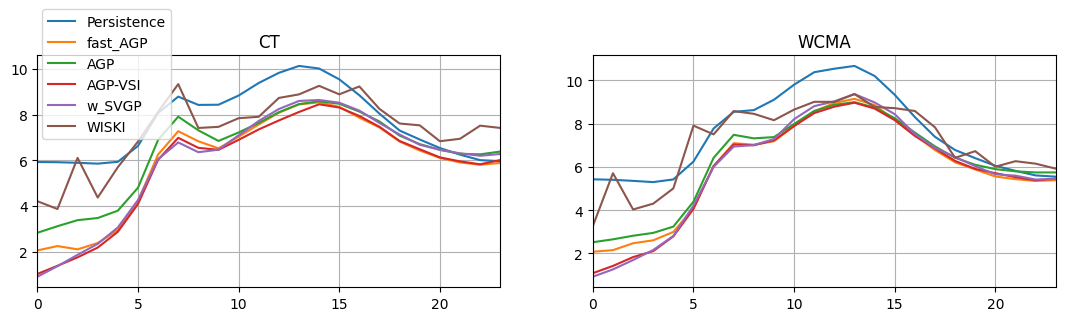

In [32]:
fig, axs = plt.subplots(figsize=(12, 4))

plt.tight_layout(pad=5.)
for i, region in enumerate(['CT', 'WCMA']):
    X_init, y_init, X_t, y_t  = generate_data(region)
    
    with open('../results/LF_Persistence_'+region+'.pickle', 'rb') as handle:
        data_Persistence = pickle.load(handle)
            
    with open('../results/LF_Fast-AGP_'+region+'.pickle', 'rb') as handle:
        data_fast_AGP = pickle.load(handle)

    with open('../results/LF_AGP_'+region+'.pickle', 'rb') as handle:
        data_AGP = pickle.load(handle)

    with open('../results/LF_AGP-VSI_'+region+'.pickle', 'rb') as handle:
        data_AGP_VSI = pickle.load(handle)
        
    with open('../results/LF_w-SVGP_'+region+'.pickle', 'rb') as handle:
        data_w_SVGP = pickle.load(handle)
    try:
        with open('../results/LF_OSGP_'+region+'.pickle', 'rb') as handle:
            data_OSGP= pickle.load(handle)
    except:
        data_OSGP=[]
        OSGP=[]

    with open('../results/LF_WISKI_'+region+'.pickle', 'rb') as handle:
        data_WISKI = pickle.load(handle)
      
    plt.subplot(1,2,i+1)

    Persistence = np.mean((np.sqrt(np.array(data_Persistence['mse'])).T/np.array(y_t).T), axis=1)
    fast_AGP=np.mean((np.sqrt(np.squeeze(np.array(data_fast_AGP['mse'])))/np.array(y_t).T), axis=1).T
    AGP=np.mean((np.sqrt(np.squeeze(np.array(data_AGP['mse'])))/np.array(y_t).T), axis=1).T
    AGP_VSI=np.mean((np.sqrt(np.squeeze(np.array(data_AGP_VSI['mse'])))/np.array(y_t).T), axis=1).T
    w_SVGP=np.mean((np.sqrt(np.squeeze(np.array(data_w_SVGP['mse'])))/np.array(y_t).T), axis=1).T
    try:
        OSGP=np.mean(np.sqrt(np.squeeze(np.array(data_OSGP['mse'])))/np.array(y_t).T, axis=1).T
    except:
        pass
    WISKI=np.mean((np.sqrt(np.squeeze(np.array(data_WISKI['mse'])))/np.array(y_t).T), axis=1).T


    plt.plot(100*Persistence.T, label='Persistence')
    plt.plot(100*fast_AGP.T, label='fast_AGP')
    plt.plot(100*AGP.T, label='AGP')
    plt.plot(100*AGP_VSI.T, label='AGP-VSI')
    plt.plot(100*w_SVGP.T, label='w_SVGP')
    plt.plot(100*WISKI.T, label='WISKI')
    plt.xlim(0.,23.)
    #try:
    #    plt.plot(100*OSGP.T, label='OSGP')
    #except:
    #    pass
    plt.grid()
    plt.title(region)
    if i==0:
        plt.legend(bbox_to_anchor=(0.01, 1.2), loc='upper left', borderaxespad=0.)
fig.savefig('../results/figs/MAPE_all.pdf')